Step 1: Imports

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from cifar10.model import Net, getNorm
from cifar10.backpropogation import test, train
from cifar10.visualize import plot_misclassified_images, plot_network_performance
from cifar10.backpropogation import train_losses, train_acc, test_losses, test_acc, incorrect_examples, incorrect_pred, incorrect_labels

!pip install torchsummary
from torchsummary import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Step 2: Visualize and Prepare Data Transforms

100%|██████████| 170498071/170498071 [00:05<00:00, 31459613.39it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


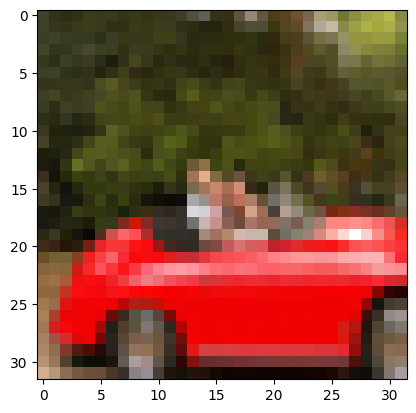

In [2]:
cifar10 =  datasets.CIFAR10('./data', train=True, download=True)
cifar10_val = datasets.CIFAR10('./data', train=False, download=True)
img, label = cifar10[99]
plt.imshow(img)
plt.show()

In [3]:
train_transforms = transforms.Compose([transforms.RandomRotation((-6.0, 6.0), fill=(1,1,1)),
                                       #transforms.ShiftScaleRotate(shift_limit=0.09, scale_limit=0.09, rotate_limit=7, p=0.3),
                                       #transforms.Grayscale(),
                                       #transforms.RandomBrightnessContrast(p=0.5),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784))])
test_transforms = transforms.Compose([transforms.ToTensor(),
                                       #transforms.Grayscale(),
                                       transforms.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784))])

Step 3: Creating datasets

In [4]:
train_data = datasets.CIFAR10('./data', train = True, download=True, transform=train_transforms)
test_data = datasets.CIFAR10('./data', train = False, download = True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


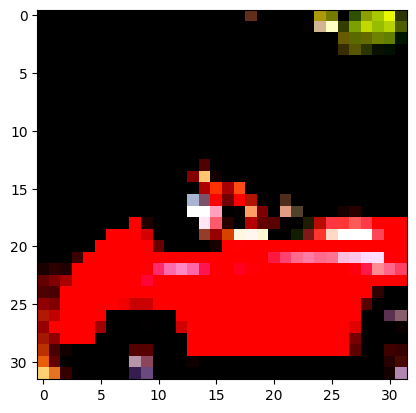

In [5]:
import matplotlib.pyplot as plt
img, label = train_data[99]

plt.imshow(img.permute(1,2,0))

Step 4: Creating data loaders

In [6]:
SEED = 1

cuda = torch.cuda.is_available()
print("Is cuda available? ", cuda)

#set the seed of the random number generator to a fixed value
torch.manual_seed(SEED)

if cuda:
  torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle = True, batch_size = 128, num_workers=4, pin_memory = True) if cuda else dict(shuffle=True, batch_size=64)

train_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)
test_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)


Is cuda available?  True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Step 5: Data Stats

In [7]:
classes = train_data.classes
class_count = {}
for _, index in train_data:
    label = classes[index]
    if label not in class_count:
        class_count[label] = 0
    class_count[label] += 1
class_count

{'frog': 5000,
 'truck': 5000,
 'deer': 5000,
 'automobile': 5000,
 'bird': 5000,
 'horse': 5000,
 'ship': 5000,
 'cat': 5000,
 'dog': 5000,
 'airplane': 5000}

In [8]:
data = train_data.data / 255 # data is numpy array

mean = data.mean(axis = (0,1,2))
std = data.std(axis = (0,1,2))
print(f"Mean : {mean}   STD: {std}")

Mean : [0.49139968 0.48215841 0.44653091]   STD: [0.24703223 0.24348513 0.26158784]


images.shape: torch.Size([128, 3, 32, 32])


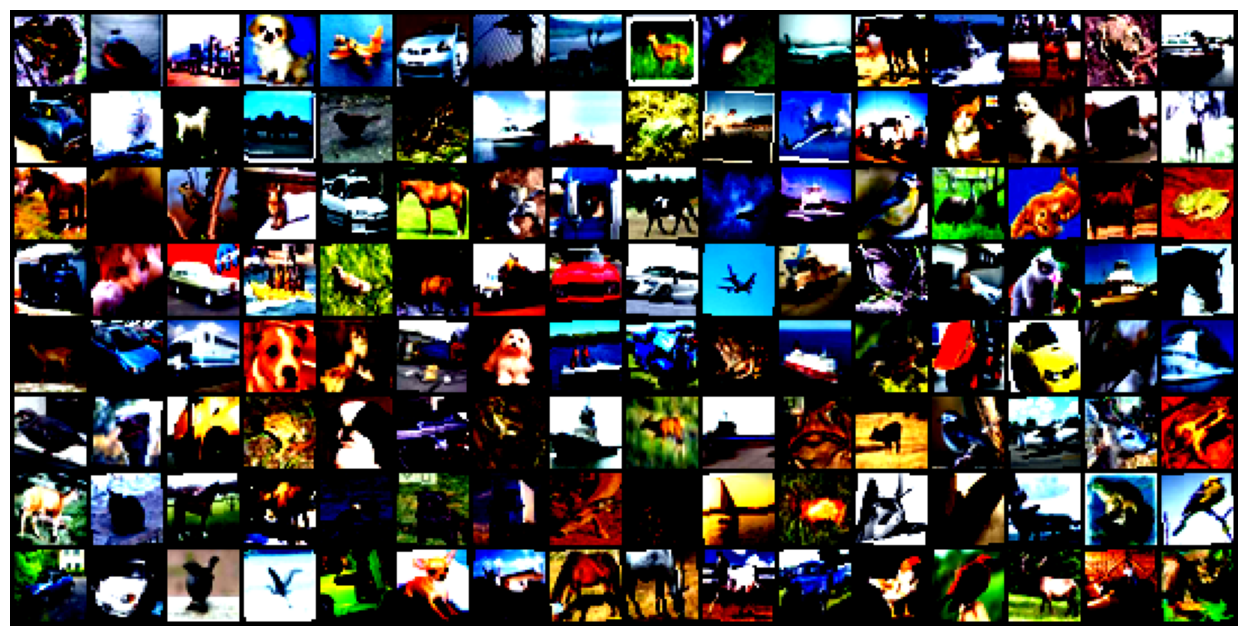

In [9]:
# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

Step 6: Model Creation and Display Parameters

In [10]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

model = Net(norm='bn', GROUP_SIZE = 1).to(device)
summary(model, input_size=(3,32,32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           4,608
       BatchNorm2d-6           [-1, 32, 32, 32]              64
              ReLU-7           [-1, 32, 32, 32]               0
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 16, 32, 32]             512
        MaxPool2d-10           [-1, 16, 16, 16]               0
           Conv2d-11           [-1, 16, 16, 16]           2,304
      BatchNorm2d-12           [-1, 16, 16, 16]              32
             ReLU-13           [-1, 16, 16, 16]               0
          Dropout-14           [-1

Step 7: Model with Batch Normalization

In [11]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.1)
EPOCHS = 21
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    print(f"\n current learing rate is {optimizer.param_groups[0]['lr']}")
    test(model, device, test_loader)

EPOCH: 0


Loss=1.0882771015167236 Batch_id=390 Accuracy=44.19: 100%|██████████| 391/391 [00:22<00:00, 17.60it/s]


 current learing rate is 0.01



Test set: Average loss: 1.3923, Accuracy: 4977/10000 (49.77%)

EPOCH: 1


Loss=0.9884207844734192 Batch_id=390 Accuracy=59.33: 100%|██████████| 391/391 [00:22<00:00, 17.09it/s]


 current learing rate is 0.01



Test set: Average loss: 1.1408, Accuracy: 5977/10000 (59.77%)

EPOCH: 2


Loss=1.0047001838684082 Batch_id=390 Accuracy=64.77: 100%|██████████| 391/391 [00:23<00:00, 16.49it/s]



 current learing rate is 0.01

Test set: Average loss: 0.9457, Accuracy: 6659/10000 (66.59%)

EPOCH: 3


Loss=0.7854284644126892 Batch_id=390 Accuracy=68.06: 100%|██████████| 391/391 [00:22<00:00, 17.67it/s]


 current learing rate is 0.01



Test set: Average loss: 0.9413, Accuracy: 6677/10000 (66.77%)

EPOCH: 4


Loss=0.8533415794372559 Batch_id=390 Accuracy=70.26: 100%|██████████| 391/391 [00:21<00:00, 18.20it/s]


 current learing rate is 0.01



Test set: Average loss: 0.8071, Accuracy: 7204/10000 (72.04%)

EPOCH: 5


Loss=0.752530574798584 Batch_id=390 Accuracy=71.95: 100%|██████████| 391/391 [00:21<00:00, 18.11it/s]


 current learing rate is 0.001



Test set: Average loss: 0.8513, Accuracy: 7040/10000 (70.40%)

EPOCH: 6


Loss=0.7947073578834534 Batch_id=390 Accuracy=75.00: 100%|██████████| 391/391 [00:21<00:00, 18.28it/s]


 current learing rate is 0.001



Test set: Average loss: 0.7034, Accuracy: 7550/10000 (75.50%)

EPOCH: 7


Loss=0.5671007633209229 Batch_id=390 Accuracy=75.74: 100%|██████████| 391/391 [00:23<00:00, 16.98it/s]


 current learing rate is 0.001



Test set: Average loss: 0.6873, Accuracy: 7591/10000 (75.91%)

EPOCH: 8


Loss=0.6520595550537109 Batch_id=390 Accuracy=76.10: 100%|██████████| 391/391 [00:23<00:00, 16.90it/s]


 current learing rate is 0.001



Test set: Average loss: 0.6850, Accuracy: 7608/10000 (76.08%)

EPOCH: 9


Loss=0.7260794639587402 Batch_id=390 Accuracy=76.19: 100%|██████████| 391/391 [00:22<00:00, 17.25it/s]


 current learing rate is 0.001



Test set: Average loss: 0.6772, Accuracy: 7662/10000 (76.62%)

EPOCH: 10


Loss=0.6060743927955627 Batch_id=390 Accuracy=76.64: 100%|██████████| 391/391 [00:22<00:00, 17.11it/s]


 current learing rate is 0.001



Test set: Average loss: 0.6692, Accuracy: 7655/10000 (76.55%)

EPOCH: 11


Loss=0.8418123126029968 Batch_id=390 Accuracy=76.35: 100%|██████████| 391/391 [00:22<00:00, 17.14it/s]


 current learing rate is 0.0001



Test set: Average loss: 0.6818, Accuracy: 7658/10000 (76.58%)

EPOCH: 12


Loss=0.5850874781608582 Batch_id=390 Accuracy=76.91: 100%|██████████| 391/391 [00:23<00:00, 16.44it/s]


 current learing rate is 0.0001



Test set: Average loss: 0.6721, Accuracy: 7656/10000 (76.56%)

EPOCH: 13


Loss=0.7994786500930786 Batch_id=390 Accuracy=77.14: 100%|██████████| 391/391 [00:22<00:00, 17.66it/s]


 current learing rate is 0.0001



Test set: Average loss: 0.6601, Accuracy: 7701/10000 (77.01%)

EPOCH: 14


Loss=0.654018759727478 Batch_id=390 Accuracy=76.99: 100%|██████████| 391/391 [00:22<00:00, 17.71it/s]


 current learing rate is 0.0001



Test set: Average loss: 0.6599, Accuracy: 7695/10000 (76.95%)

EPOCH: 15


Loss=0.6911498308181763 Batch_id=390 Accuracy=77.02: 100%|██████████| 391/391 [00:21<00:00, 17.92it/s]


 current learing rate is 0.0001



Test set: Average loss: 0.6628, Accuracy: 7679/10000 (76.79%)

EPOCH: 16


Loss=0.713415801525116 Batch_id=390 Accuracy=77.19: 100%|██████████| 391/391 [00:21<00:00, 18.20it/s]


 current learing rate is 0.0001



Test set: Average loss: 0.6613, Accuracy: 7696/10000 (76.96%)

EPOCH: 17


Loss=0.6773367524147034 Batch_id=390 Accuracy=77.25: 100%|██████████| 391/391 [00:21<00:00, 18.04it/s]


 current learing rate is 1e-05



Test set: Average loss: 0.6730, Accuracy: 7656/10000 (76.56%)

EPOCH: 18


Loss=0.8078063726425171 Batch_id=390 Accuracy=77.40: 100%|██████████| 391/391 [00:23<00:00, 16.96it/s]


 current learing rate is 1e-05



Test set: Average loss: 0.6642, Accuracy: 7679/10000 (76.79%)

EPOCH: 19


Loss=0.7118920087814331 Batch_id=390 Accuracy=77.31: 100%|██████████| 391/391 [00:21<00:00, 18.09it/s]


 current learing rate is 1e-05



Test set: Average loss: 0.6685, Accuracy: 7667/10000 (76.67%)

EPOCH: 20


Loss=0.500490128993988 Batch_id=390 Accuracy=77.15: 100%|██████████| 391/391 [00:22<00:00, 17.71it/s]


 current learing rate is 1e-05



Test set: Average loss: 0.6664, Accuracy: 7681/10000 (76.81%)



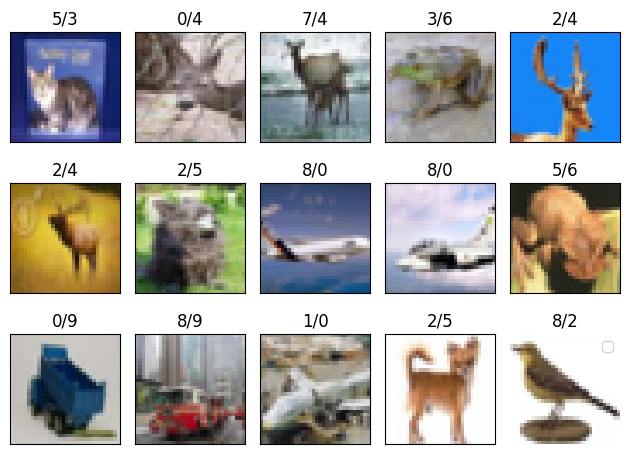

In [14]:
plot_misclassified_images(incorrect_examples, incorrect_pred, incorrect_labels)


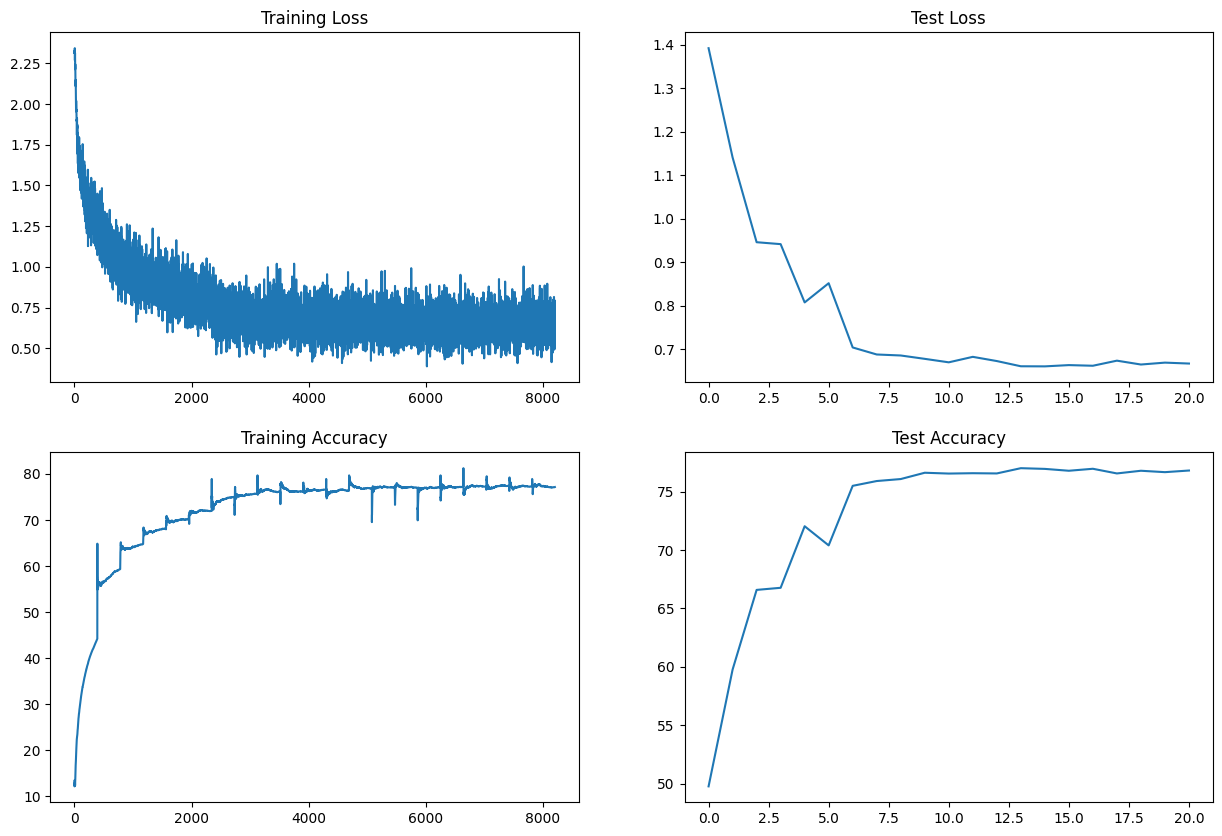

In [15]:
new_tensor = torch.tensor(train_losses, device = 'cpu')
plot_network_performance(new_tensor, test_losses, train_acc, test_acc)